# Creative Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [15]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.


In [3]:
import requests
import os

def download_file(book_name):
    base_url = "https://raw.githubusercontent.com/UofT-DSI/deep_learning/refs/heads/main/02_activities/assignments/downloaded_books/"
    file_url = base_url + book_name
    local_filename = book_name

    response = requests.get(file_url)
    if response.status_code == 200:
        with open(local_filename, 'w', encoding='utf-8') as f:
            f.write(response.text)
        print(f"Downloaded {book_name} successfully!")
        return local_filename
    else:
        raise ValueError("Failed to download the file. Please check the filename and try again.")

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

# Prompt user to select a book
title_options = {
    "1": "charles_dickens.txt",
    "2": "mark_twain.txt",
    "3": "shakespeare.txt"
}

print("Choose a book to download:")
print("1: Charles Dickens")
print("2: Mark Twain")
print("3: William Shakespeare")

choice = None
while choice not in title_options:
    choice = input("Enter the number corresponding to your choice (1, 2, or 3): ").strip()
    if choice not in title_options:
        print("Invalid choice. Please enter 1, 2, or 3.")

selected_book = title_options[choice]
file_path = download_file(selected_book)

# Load chosen dataset
fraction = 0.03  # Adjust fraction if running out of memory
text = load_dataset(file_path, fraction=fraction)

print("Dataset loaded successfully!")

Choose a book to download:
1: Charles Dickens
2: Mark Twain
3: William Shakespeare
Enter the number corresponding to your choice (1, 2, or 3): 1
Downloaded charles_dickens.txt successfully!
Dataset loaded successfully!


# 1. Data Preparation (10 Marks)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration (3 Marks)

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [4]:
# Solution
print(text[:1000])
print('The dataset contains {} characters.'.format(len(text)))
unique_chars = sorted(set(text))
print('The dataset contains {} unique characters.'.format(len(unique_chars)))

The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: A Tale of Two Cities
       A Story of the French Revolution

Author: Charles Dickens

Release Date: January, 1994 [eBook #98]
[Most recently updated: December 20, 2020]

Language: English

Character set encoding: UTF-8

Produced by: Judith Boss and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK A TALE OF TWO CITIES ***




A TALE OF TWO CITIES

A STORY OF THE FRENCH REVOLUTION

By Charles Dickens


CONTENTS


     Book the First--Recalled to Life

     CHAPTER I 

## 1.2 Text Pre-Processing (4 Marks)

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [5]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

VOCAB_SIZE = 5000
OOV_TOKEN = "<OOV>"

# Convert the entire text to lowercase
text = text.lower().replace("’", "").replace("”", "") #also remove curly apostrophes

# Split the text into sentences based on . ? !
sentences_lower = re.split(r'[.?!]\s*', text)

#text_lower= sentences.lower().split()

#Split into testing and training
texts_train, texts_test = train_test_split(sentences_lower, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN, char_level= False, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\'’”')
tokenizer.fit_on_texts(texts_train)

If everything worked, the following line should show you the first 10 words in the vocabulary:

In [6]:
print(list(tokenizer.word_index.items())[:10])

[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('his', 8), ('it', 9), ('he', 10)]


## 1.3 Sequence Generation (3 Marks)

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [7]:
SEQ_LENGTH = 18

# Convert the text to a list of sequences of numbers
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

# Generate the training sequences
X = []
y = []

for seq in sequences_train:
    #print(f'Sequence length: {len(seq)}')
    for i in range(0, max(0,len(seq) - SEQ_LENGTH)): #range from i-th word to the end of the seq, max is to handle sequences <12 words
        # Target index to keep track of the index of the target word
        target_index = i + SEQ_LENGTH

        if target_index < len(seq):  #only incl target if within range
          input_sequence = seq[i:i + SEQ_LENGTH] #input is the i-th word up to but excluding the last word of a seq
          target = seq[target_index]
          X.append(input_sequence)
          y.append(target)
#print(f'Generated {len(X)} sequences.')


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [8]:
print(f'Sequence: {X[0]}\nTarget: {y[0]}')
print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')

Sequence: [4, 8, 4654, 282, 3, 629, 158, 15, 2, 92, 1663, 1129, 652, 11, 2, 363, 12, 87]
Target: 21
Translated back to words: ['of', 'his', 'pleasures', 'general', 'and', 'particular', 'monseigneur', 'had', 'the', 'other', 'truly', 'noble', 'idea', 'that', 'the', 'world', 'was', 'made'] -> for


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
mask = y != tokenizer.word_index[OOV_TOKEN]
X = X[mask]
y = y[mask]

# One-hot encode the target token
y = to_categorical(y, num_classes=VOCAB_SIZE)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (24308, 18)
y_train shape: (24308, 5000)


# 2. Model Development (10 Marks)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture (4 Marks)

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout

EMBEDDING_DIM = 64
VOCAB_SIZE = 5000 #try reducing this to increase acc
SEQ_LENGTH = 18 #increasing seq length might provide more context to model

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_shape=(SEQ_LENGTH,), trainable=True), #transform orig vocab to embedding
    LSTM(128, return_sequences=True), #this step outputs 128 units which are interconnected LSTMs
    LSTM(128),
    Dense(VOCAB_SIZE, activation='softmax')
])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 18, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 18, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5000)                │         645,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,195,400 (4.56 MB)

 Trainable params: 1,195,400 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation (3 Marks)

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

Loss is calculated from the categorical cross entropy loss function which is commonly used in categorical predictions; it compares the actual to the predicted word.
Adam optimizer is used because it has flexible learning rates and biases.

In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

## 2.3 Model Training (3 Marks)

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [16]:
# Train the model
history= model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=5, batch_size=128)

Epoch 1/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 37s 171ms/step - acc: 0.0571 - loss: 7.1857 - val_acc: 0.0694 - val_loss: 6.4149
Epoch 2/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - acc: 0.0660 - loss: 6.2317 - val_acc: 0.0691 - val_loss: 6.3162
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - acc: 0.0761 - loss: 6.0668 - val_acc: 0.0831 - val_loss: 6.2913
Epoch 4/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 45s 176ms/step - acc: 0.0888 - loss: 5.9607 - val_acc: 0.0917 - val_loss: 6.2419
Epoch 5/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - acc: 0.1016 - loss: 5.8014 - val_acc: 0.1010 - val_loss: 6.2184


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

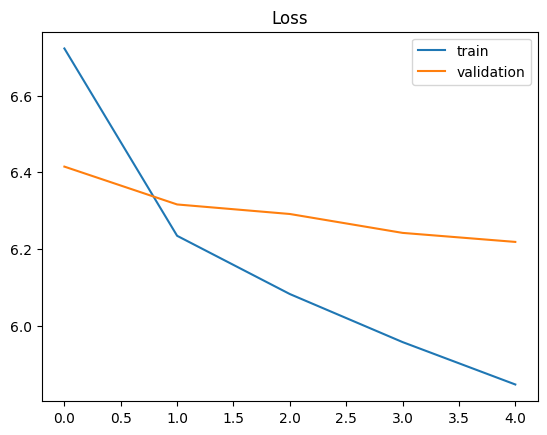

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.legend(loc='best')
plt.title('Loss');

#model is overfit

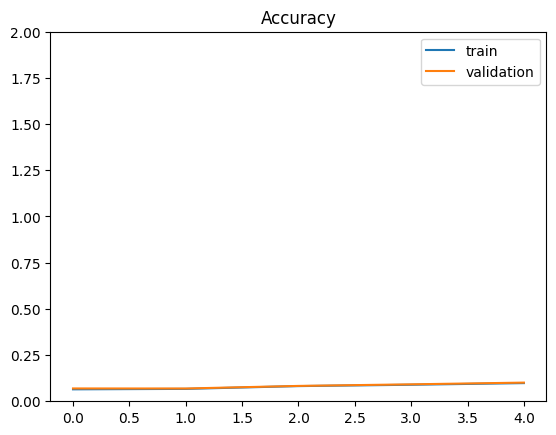

In [18]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')

plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Accuracy');

#accuracy is poor

# 3. Text Generation (10 Marks)

## Task Overview

In this task, you will write a function called `generate_text` that uses a trained RNN model to generate new text based on a given seed phrase.

Your function **must** follow a structured approach to text generation, where the model predicts one word at a time, adds it to the sequence, and repeats this process until a desired length is reached.

## Function Requirements

You need to implement a function with the following signature:

```python
def generate_text(model, tokenizer, seed_text, max_sequence_len, n_words=100):
```

### **Parameters**
- `model`: The trained RNN model that will generate text.
- `tokenizer`: The tokenizer used to convert words to numerical sequences.
- `seed_text`: The initial text that will be used to start generating words.
- `max_sequence_len`: The maximum length of input sequences (same as used in training).
- `n_words` (optional, default=100): The number of words to generate.

### **Expected Output**
- A single **string** containing the generated text.

---

## **Step-by-Step Instructions**

### **1. Tokenize the seed text**
Use the tokenizer to convert `seed_text` into a sequence of numbers:

```python
encoded = tokenizer.texts_to_sequences([seed_text])[0]
```

### **2. Pad the sequence to match training input length**
Ensure that the sequence is the correct length by padding it **at the beginning**:

```python
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoded = pad_sequences([encoded], maxlen=max_sequence_len, truncating='pre')
```

### **3. Predict the next word**
Pass the padded sequence to the model to predict the next word.

- The model will output a probability distribution over the vocabulary.
- Use `np.random.choice` or `np.argmax` to select the most likely word.

```python
yhat = model.predict(encoded, verbose=0)
predicted_word_index = np.argmax(yhat)  # Select the word with the highest probability
```

### **4. Convert the predicted word index to a word**
Find the corresponding word in the tokenizer’s vocabulary:

```python
out_word = tokenizer.index_word[predicted_word_index]
```

### **5. Append the new word to the generated text**
- Add the predicted word to `seed_text`.
- Repeat the process to generate multiple words.

```python
seed_text += " " + out_word
```

### **6. Repeat Steps 3-5 until `n_words` have been generated**

- Each time, remove the oldest word from the input sequence to keep its length constant.
- Continue generating words one at a time until reaching `n_words`.

---

## **Important Notes**
- If the generated text doesn’t make much sense, don’t worry! The quality will improve as the model is trained better.
- This is a **challenging** task! If you get stuck, ask for help.
- The `generate_text` function should return the **full generated text as a single string**.

### **Example Usage**
After implementing `generate_text`, you should be able to call it like this:

```python
generated_text = generate_text(model, tokenizer, "Once upon a time", max_sequence_len=20, n_words=50)
print(generated_text)
```

This should output a string of 50 words generated by the model, starting with `"Once upon a time"`.

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text(model, tokenizer, seed_text, max_sequence_len, n_words=100):

  #1. convert seed to a seq of numbers
  encoded= tokenizer.texts_to_sequences([seed_text])[0]

  #2. pad the seq at the beginning to reach input length
  encoded = pad_sequences([encoded], maxlen=max_sequence_len, truncating='pre')

  output_text= seed_text

  while len(output_text.split()) < n_words:

    #3. predict the next word's index
    yhat= model.predict(encoded, verbose=0)
    predicted_word_index= np.argmax(yhat)

    #4. convert predicted index into a word. Find the corresponding word in the tokenizer’s vocab
    out_word= tokenizer.index_word[predicted_word_index]

    #5. append
    output_text += " " + out_word

    #update encoded
    encoded= tokenizer.texts_to_sequences([output_text])[0]
    encoded = pad_sequences([encoded], maxlen=max_sequence_len, truncating='pre')
    #print(encoded) # to make sure encoded padding is correct

  return output_text

In [20]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH, 20 )

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2 105]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2 105  61]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   1   2 105  61   4]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   1   2 105  61   4   2]]
[[  0   0   0   0   0   0   0   0   0   0   0   1   2 105  61   4   2 105]]
[[  0   0   0   0   0   0   0   0   0   0   1   2 105  61   4   2 105  61]]
[[  0   0   0   0   0   0   0   0   0   1   2 105  61   4   2 105  61   4]]
[[  0   0   0   0   0   0   0   0   1   2 105  61   4   2 105  61   4   2]]
[[  0   0   0   0   0   0   0   1   2 105  61   4   2 105  61   4   2 105]]
[[  0   0   0   0   0   0   1   2 105  61   4   2 105  61   4   2 105  61]]
[[  0   0   0   0   0   1   2 105  61   4   2 105  61   4   2 105  61   4]]
[[  0   0   0   0   1   2 105  61   4   2 105  61   4   2 105  61   4   2]]
[[  0   0   0   1   2 105  61   4   2 105  61   

'hamlet the own man of the own man of the own man of the own man of the own man'

# 4. Model Refinement (5 Marks)

## **Understanding Your Model's Performance**

At this stage, you might have noticed that the text generated by your model doesn’t make much sense yet. **This is completely expected!**

There are a few reasons why:
1. **RNNs have limitations** – While they can generate sequences, they struggle with long-range dependencies in text.
2. **Character-by-character generation is outdated** – Modern models like ChatGPT don’t generate text one letter at a time. Instead, they use **tokens**, which represent larger chunks of words, making their outputs much more coherent.
3. **Training time and data size** – Our model has been trained on a relatively small dataset for a short period of time, which means it hasn’t learned enough patterns to generate meaningful text.

Even though we don’t expect ChatGPT-level performance, this exercise is about **experimentation, not perfection**. Your goal here is to try **at least one** way to refine your model and observe how it affects the output.

---

## **Refining Your Model**
There are many ways to try improving your model. Here are some ideas:

✅ **Use pre-trained embeddings**  
   Instead of learning word representations from scratch, you can use pre-trained word embeddings. This allows your model to start with a better understanding of word relationships.

✅ **Modify the model architecture**  
   - Experiment with **more layers** or different numbers of units per layer.  
   - Try adding **dropout layers** to prevent overfitting.  
   - Consider using **bidirectional RNNs**, which process text in both forward and backward directions.  

✅ **Train for longer**  
   - Try increasing the number of **epochs** (but be mindful of overfitting).  
   - Experiment with different **batch sizes** to see if they affect training stability.  

Again, **perfection is NOT the goal here** – we just want to see that you experimented with improving your model! 🚀

In [12]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-08 23:52:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2025-03-08 23:54:45 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [13]:
# Load the pre-trained embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [14]:
# Create an embedding matrix
VOCAB_SIZE= 5000
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [17]:
embedding_layer = Embedding(
    VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False
)

In [ ]:
#Build model with pre-trained embeddings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

VOCAB_SIZE = 5000
SEQ_LENGTH = 18

model2 = Sequential([
    embedding_layer, #use embedding layer defined above
    LSTM(128,return_sequences=True),
    LSTM(128),
    Dense(VOCAB_SIZE, activation='softmax')
])

model2.build(input_shape=(None, SEQ_LENGTH))
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 18, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 18, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5000)                │         645,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,393,832 (5.32 MB)

 Trainable params: 893,832 (3.41 MB)

 Non-trainable params: 500,000 (1.91 MB)

In [ ]:
# Compile model2
model2.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

# Train model2
history2= model2.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=128)

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - acc: 0.0632 - loss: 7.0575 - val_acc: 0.0694 - val_loss: 6.4086
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 31s 164ms/step - acc: 0.0685 - loss: 6.2508 - val_acc: 0.0694 - val_loss: 6.3208
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - acc: 0.0791 - loss: 6.1185 - val_acc: 0.1017 - val_loss: 6.2514
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - acc: 0.0945 - loss: 6.0159 - val_acc: 0.1037 - val_loss: 6.1897
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - acc: 0.1009 - loss: 5.8711 - val_acc: 0.1081 - val_loss: 6.1392
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - acc: 0.1045 - loss: 5.7471 - val_acc: 0.1073 - val_loss: 6.1139
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - acc: 0.1081 - loss: 5.6655 - val_acc: 0.1145 - val_loss: 6.1083
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - acc: 0.1139 - loss: 5.5918 - val_acc: 0.1173 - val_loss: 6.0845
Epoch 9/10
190/190 ━━━━━━━━━━━━━

In [ ]:
# Test the text generation function using model2
generate_text(model2, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet of the wine of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time of the time'

In [ ]:
#Build another model without pre-trained embeddings, include bidirectional LSTM and layer normalization
from tensorflow.keras.layers import LayerNormalization

VOCAB_SIZE = 5000
SEQ_LENGTH = 18

model3 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_shape=(SEQ_LENGTH,), trainable=True),
    Bidirectional(LSTM(128,return_sequences=True)),
    Bidirectional(LSTM(128)),
    LayerNormalization(),
    Dense(VOCAB_SIZE, activation='softmax')
])

#model3.build(input_shape=(None, SEQ_LENGTH))
model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 18, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 18, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 256)                 │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5000)                │       1,285,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,414,248 (9.21 MB)

 Trainable params: 2,414,248 (9.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model3
model3.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

# Train model3
history3= model3.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=128)

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 74s 347ms/step - acc: 0.0604 - loss: 6.9390 - val_acc: 0.0694 - val_loss: 6.4678
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 82s 346ms/step - acc: 0.0718 - loss: 6.2516 - val_acc: 0.0956 - val_loss: 6.2692
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 71s 374ms/step - acc: 0.0981 - loss: 5.9064 - val_acc: 0.1007 - val_loss: 6.1596
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 76s 341ms/step - acc: 0.1124 - loss: 5.6634 - val_acc: 0.1149 - val_loss: 6.1030
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 84s 352ms/step - acc: 0.1271 - loss: 5.4461 - val_acc: 0.1224 - val_loss: 6.1027
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 86s 373ms/step - acc: 0.1357 - loss: 5.2697 - val_acc: 0.1221 - val_loss: 6.1629
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - acc: 0.1420 - loss: 5.0753 - val_acc: 0.1292 - val_loss: 6.2117
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 82s 346ms/step - acc: 0.1481 - loss: 4.9086 - val_acc: 0.1260 - val_loss: 6.2555
Epoch 9/10
190/190 ━━━━━━━━━━━━━

In [ ]:
# Test the text generation function using model3
generate_text(model3, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet and to be agreeable was so husband to her husband to her husband to her husband to the little street and had been so much to be to be to be there and a little street and the little street and the little street and the little street and the little street and the little street and the little street and the little street and the little street and the little street and the little street and the little street and the little street and the little street and the little street and the little street and the little'

In [ ]:
#calculate accuracies of model2 and model3
sequences_test = tokenizer.texts_to_sequences(texts_test)

X_test = []
y_test = []

for seq in sequences_test:
   for i in range(0, max(0,len(seq) - SEQ_LENGTH)):
       target_index = i + SEQ_LENGTH
       if target_index < len(seq):
           input_sequence = seq[i:i + SEQ_LENGTH]
           target = seq[target_index]
           X_test.append(input_sequence)
           y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Drop OOV targets
mask = y_test != tokenizer.word_index[OOV_TOKEN]
X_test = X_test[mask]
y_test = y_test[mask]

y_test = to_categorical(y_test, num_classes=VOCAB_SIZE)

In [33]:
loss, accuracy = model2.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy model 2: {}'.format(accuracy))

Test Accuracy model 2: 0.1173364594578743


In [43]:
loss, accuracy = model3.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy model 3: {}'.format(accuracy))

Test Accuracy model 3: 0.1204165443778038
